- [20.2 - Hierarchical Bayesian Approach](#20.2---Hierarchical-Bayesian-Approach)

## Chapter 20 - Metric Predicted Variable with Multiple Nominal Predictors

In [2]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-whitegrid')

color = '#87ceeb'

In [3]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

### 20.2 - Hierarchical Bayesian Approach

In [20]:
df = pd.read_csv('data/Salary.csv', usecols=[0,3,5])

# Convert Org and Pos to category dtype.
df.loc[:,['Org', 'Pos']] = df.loc[:,['Org', 'Pos']].apply(lambda x: x.astype('category'))
# Reorder the Pos categories and rename categories
df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 3 columns):
Org       1080 non-null category
Pos       1080 non-null category
Salary    1080 non-null int64
dtypes: category(2), int64(1)
memory usage: 10.8 KB


In [21]:
df.groupby('Pos').apply(lambda x: x.head(2))
# I think one should be able to do df.groupby('Pos').head(3), but this produces incorrect result2.
# Pandas Bug? Have to look into this.

              Org      Pos  Salary
Pos                               
Assis   4    LGED    Assis   63796
        6    INFO    Assis   98814
Assoc   0      PL    Assoc   72395
        1    MUTH    Assoc   61017
Full    7    CRIN     Full  107745
        9     PSY     Full  173302
Endow   5    MGMT    Endow  219600
        8    CRIN    Endow  114275
Disting 29   SPEA  Disting  285000
        128  MUHI  Disting  114189

In [22]:
df.groupby('Pos').head(2)

      Org      Pos  Salary
0      PL    Assoc   72395
1    MUTH    Assoc   61017
4    LGED    Assis   63796
5    MGMT    Endow  219600
6    INFO    Assis   98814
7    CRIN     Full  107745
8    CRIN    Endow  114275
9     PSY     Full  173302
29   SPEA  Disting  285000
128  MUHI  Disting  114189

#### Model (Kruschke, 2015)

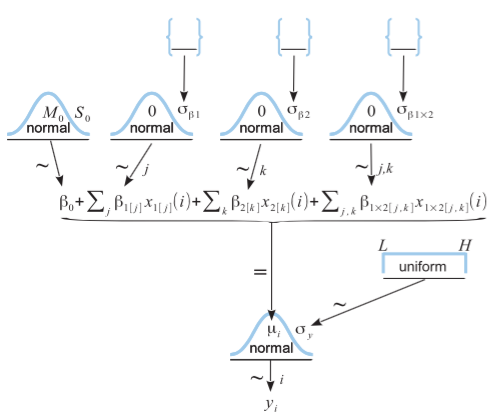

In [26]:
Image('images/fig20_2.png')

In [ ]:
  model {
    for ( i in 1:Ntotal ) {
      y[i] ~ dnorm( mu[i] , 1/ySigma^2 )
      mu[i] <- a0 + a1[x1[i]] + a2[x2[i]] + a1a2[x1[i],x2[i]]
    }
    ySigma ~ dunif( ySD/100 , ySD*10 )
    a0 ~ dnorm( yMean , 1/(ySD*5)^2 ) 
    #
    for ( j1 in 1:Nx1Lvl ) { a1[j1] ~ dnorm( 0.0 , 1/a1SD^2 ) }
    a1SD ~ dgamma(agammaShRa[1],agammaShRa[2]) # or try a folded t (Cauchy)
    #
    for ( j2 in 1:Nx2Lvl ) { a2[j2] ~ dnorm( 0.0 , 1/a2SD^2 ) }
    a2SD ~ dgamma(agammaShRa[1],agammaShRa[2]) # or try a folded t (Cauchy)
    #
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) {
      a1a2[j1,j2] ~ dnorm( 0.0 , 1/a1a2SD^2 )
    } }
    a1a2SD ~ dgamma(agammaShRa[1],agammaShRa[2]) # or try a folded t (Cauchy)
    # Convert a0,a1[],a2[],a1a2[,] to sum-to-zero b0,b1[],b2[],b1b2[,] :
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) {
      m[j1,j2] <- a0 + a1[j1] + a2[j2] + a1a2[j1,j2] # cell means 
    } }
    b0 <- mean( m[1:Nx1Lvl,1:Nx2Lvl] )
    for ( j1 in 1:Nx1Lvl ) { b1[j1] <- mean( m[j1,1:Nx2Lvl] ) - b0 }
    for ( j2 in 1:Nx2Lvl ) { b2[j2] <- mean( m[1:Nx1Lvl,j2] ) - b0 }
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) {
      b1b2[j1,j2] <- m[j1,j2] - ( b0 + b1[j1] + b2[j2] )  
    } }
  }

In [27]:
y = df.Salary
yMean = y.mean()
ySD = y.std()

x1 = df.Pos.cat.codes.values
Nx1Lvl = len(df.Pos.cat.categories)

x2 = df.Org.cat.codes.values
Nx2Lvl = len(df.Org.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD)

with pmc.Model() as model1:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a1SD = pmc.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    a1 = pmc.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a2SD = pmc.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    a2 = pmc.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    
    a1a2SD = pmc.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    a1a2 = pmc.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
        
    ySigma = pmc.Uniform('ySigma', ySD/100, ySD*10)
    mu = a0 + a1[x1] + a2[x2] +a1a2[x1, x2]
    like = pmc.Normal('y', mu, tau=1/ySigma**2, observed=y)
    
    # Convert a0,a1[],a2[],a1a2[,] to sum-to-zero b0,b1[],b2[],b1b2[,] : 
    #m = pmc.Deterministic('m', a0 + a1 + a2 + a1a2)
    #b0 = pmc.Deterministic('b0', tt.mean(m))
    #b1 = pmc.Deterministic('b1', m - b0) 
    #b2 = pmc.Deterministic('b2', m - b0)
    #b1b2 = pmc.Deterministic('b1b2', m - (b0 + b1 + b2))

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied log-transform to a1SD and added transformed a1SD_log_ to model.
Applied log-transform to a2SD and added transformed a2SD_log_ to model.
Applied log-transform to a1a2SD and added transformed a1a2SD_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.


In [ ]:
with model1:
    trace1 = pmc.sample(2500)

In [ ]:
pmc.df_summary(trace1, varnames=['a1a2']).iloc[110:]

In [24]:
# Figure 20.8 in the book shows the Salary data for four of the sixty departments.
# Let's create the subset for plotting. 
subset_org = ['BFIN', 'CHEM', 'PSY', 'ENG']
subset_df = df[df.Org.isin(subset_org)]
subset_df.groupby('Pos').head(2)

      Org      Pos  Salary
2     ENG    Assoc   82370
9     PSY     Full  173302
17    ENG    Assoc   78978
25   CHEM    Assis   80093
42    ENG    Assis   64000
48    PSY     Full  135559
67    PSY    Endow  209404
74   BFIN    Endow  252600
149  CHEM  Disting  154487
234  CHEM  Disting  248045

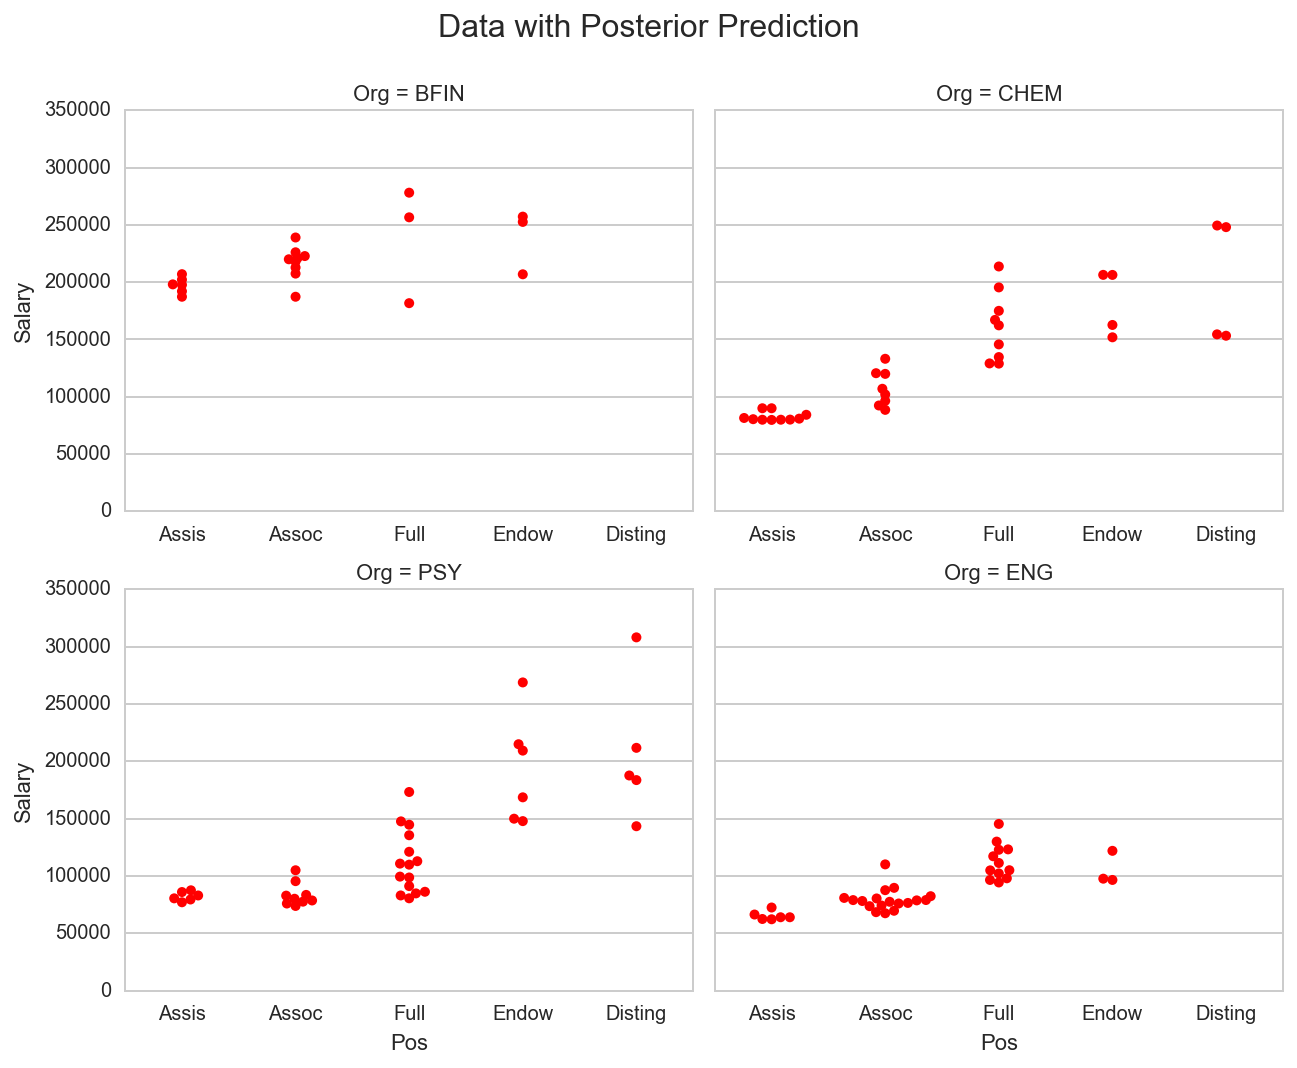

In [25]:
fg = sns.FacetGrid(subset_df, col='Org', col_order=subset_org,
                   col_wrap=2, size=3.5, aspect=1.3, despine=False, sharex=False) 
fg.map(sns.swarmplot, 'Pos', 'Salary', data=subset_df, color='r')
fg.fig.suptitle('Data with Posterior Prediction', y=1.05, fontsize=16);